In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy

from sklearn.neighbors import KNeighborsClassifier
from gtfparse import read_gtf

from tqdm import tqdm
import anndata as ad
import scanpy as sc

In [2]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
value_to_predict = 'population'


In [13]:
data_raw = pd.read_csv(fdir_raw / 'Geuvadis.all.csv', index_col=0).T
data_raw = data_raw.astype(np.float32)

data_raw_header = pd.read_csv(fdir_raw / 'Geuvadis.SraRunTable.txt', index_col=0)

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_rawdata = gtf_rawdata.to_pandas()
gtf_rawdata.set_index("transcript_id", inplace=True)
gtf_rawdata['transcript_id'] = gtf_rawdata.index
gtf_rawdata = gtf_rawdata.loc[data_raw.columns].drop_duplicates("transcript_id")

adata_raw = ad.AnnData(data_raw)
adata_raw.var = gtf_rawdata
adata_raw.obs = data_raw_header


INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


In [14]:

# sc.pp.scrublet(adata_raw, batch_key="Center Name")
# Normalizing to median total counts
sc.pp.normalize_total(adata_raw)
# Logarithmize the data
sc.pp.log1p(adata_raw)


In [23]:
adata_raw.obs['batch'] = 0

adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "CNAG"] = "0"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "CRG"] = "0"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "HMGU"] = "1"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "MPIMG"] = "2"

adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "ICMB"] = "3"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "LUMC"] = "4"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "UNIGE"] = "5"
adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "UU"] = "6"

/tmp/ipykernel_57408/4065576357.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_raw.obs['batch'].loc[adata_raw.obs['Center Name'] == "CNAG"] = "0"
/tmp/ipykernel_57408/4065576357.py:3: SettingWithCopyWarning: 
A value is trying to 

... storing 'batch' as categorical


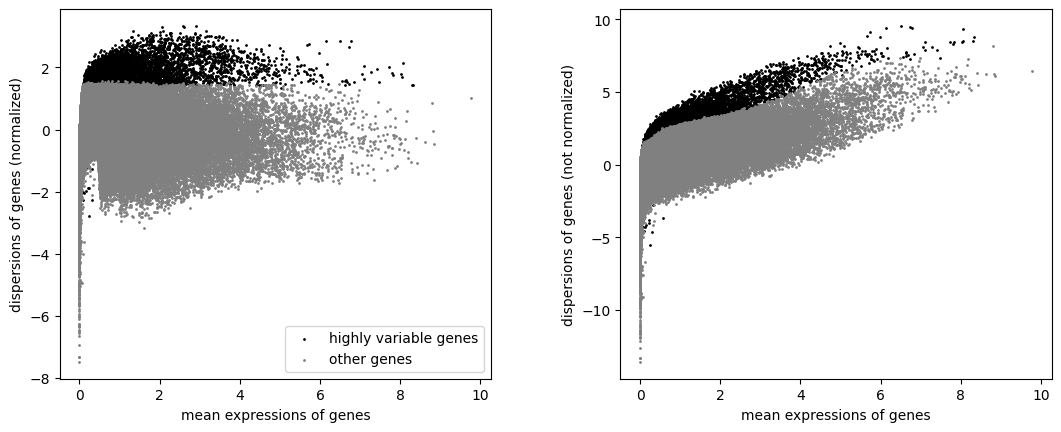

In [24]:
sc.pp.highly_variable_genes(adata_raw, n_top_genes=15000, batch_key='batch')
sc.pl.highly_variable_genes(adata_raw)


In [27]:
sc.pp.scale(adata_raw, max_value=10)


In [31]:
data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key='chrXY')
data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data.set_index("transcript_id", inplace=True)
gtf_data['transcript_id'] = gtf_data.index
gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")


INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


In [32]:
adata = ad.AnnData(data)
adata.var = gtf_data
adata.obs = data_header

# adata = adata_raw

... storing 'Assay Type' as categorical
... storing 'BioProject' as categorical
... storing 'BioSample' as categorical
... storing 'Broker_name' as categorical
... storing 'Center Name' as categorical
... storing 'common_name' as categorical
... storing 'Consent' as categorical
... storing 'DATASTORE filetype' as categorical
... storing 'DATASTORE provider' as categorical
... storing 'DATASTORE region' as categorical
... storing 'ENA-FIRST-PUBLIC (run)' as categorical
... storing 'ena_first_public' as categorical
... storing 'ENA-LAST-UPDATE (run)' as categorical
... storing 'ENA_last_update' as categorical
... storing 'Experimental_Factor:_population (exp)' as categorical
... storing 'external_id' as categorical
... storing 'INSDC_center_alias' as categorical
... storing 'INSDC_center_name' as categorical
... storing 'INSDC_first_public' as categorical
... storing 'INSDC_last_update' as categorical
... storing 'INSDC_status' as categorical
... storing 'Instrument' as categorical
... s

AvgSpotLen


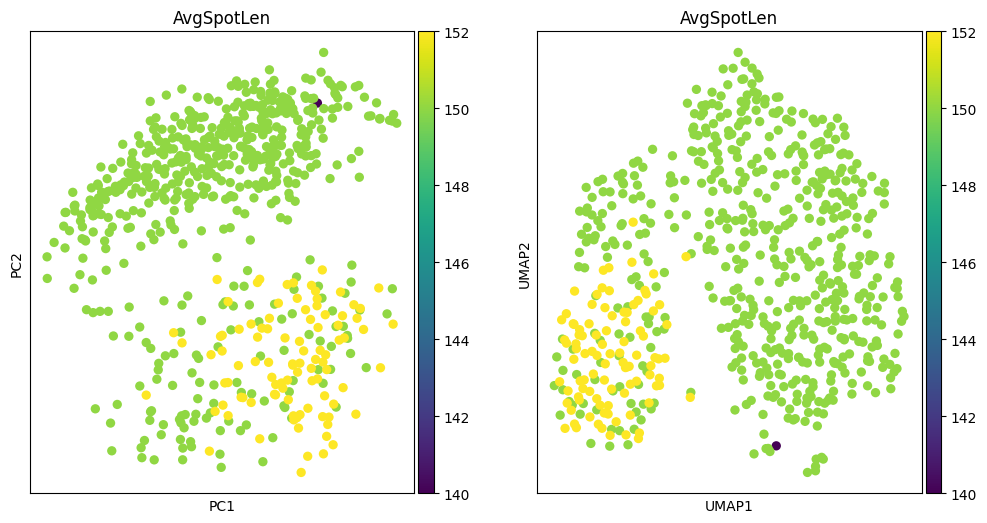

Center Name


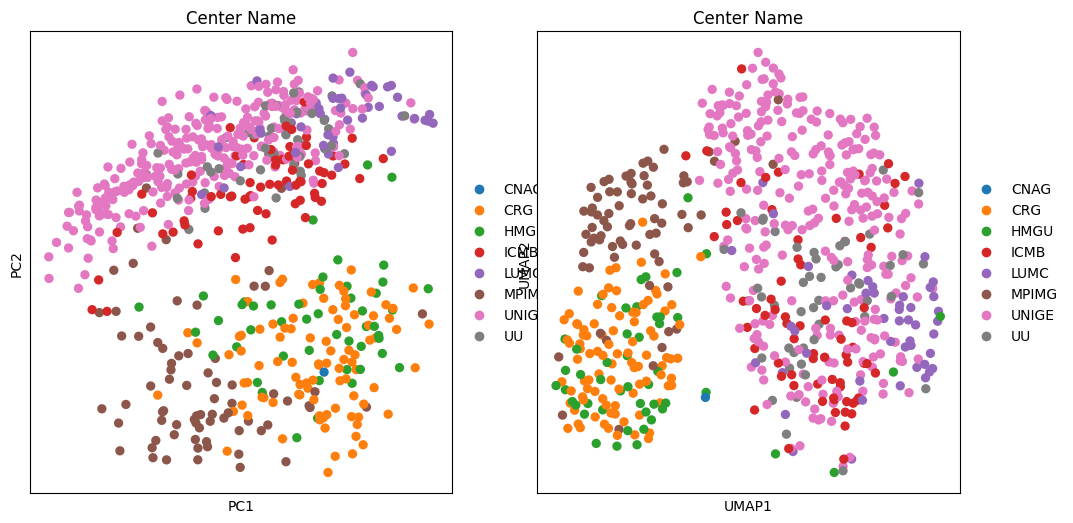

DATASTORE filetype


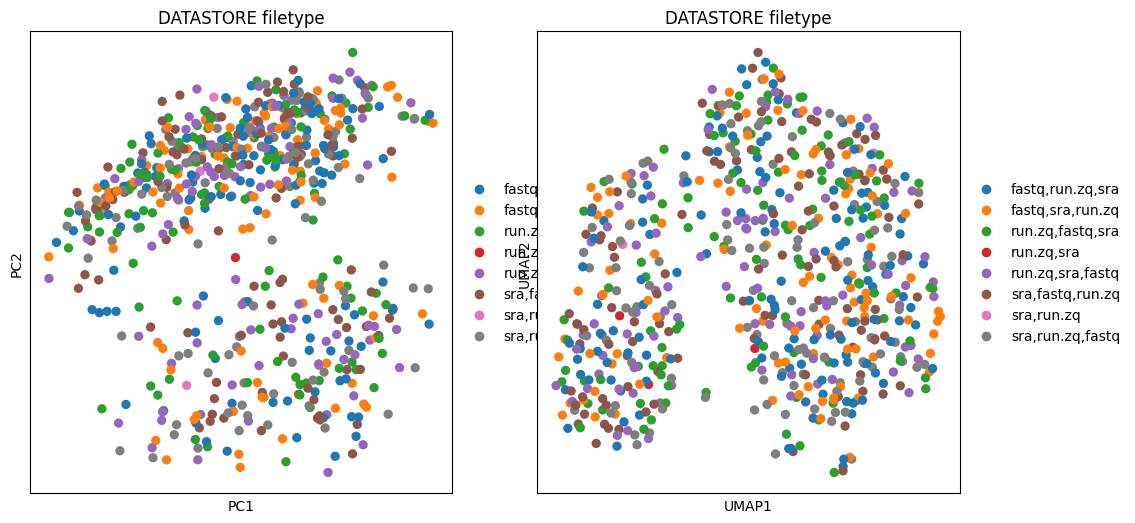

ENA-FIRST-PUBLIC (run)


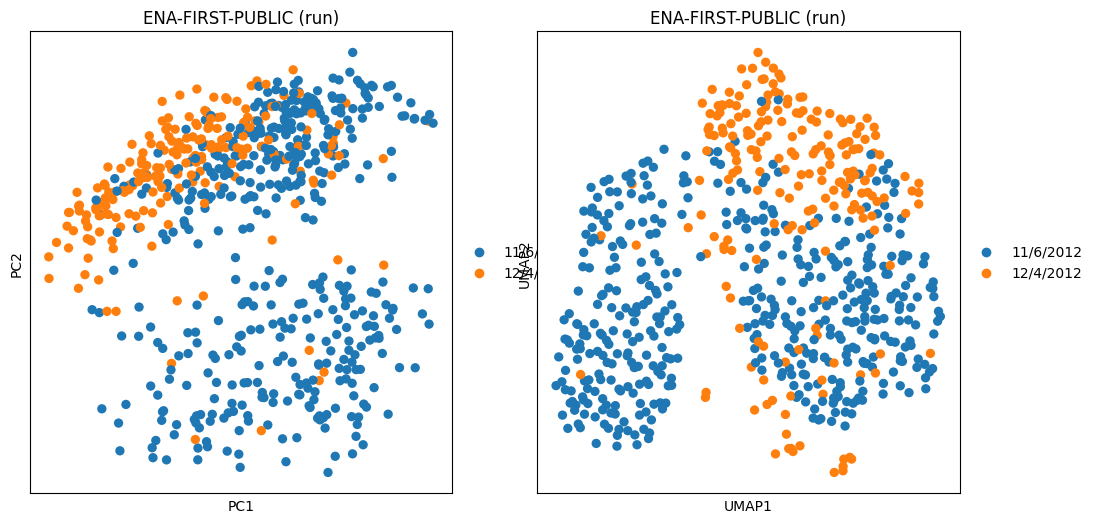

Experimental_Factor:_laboratory (exp)


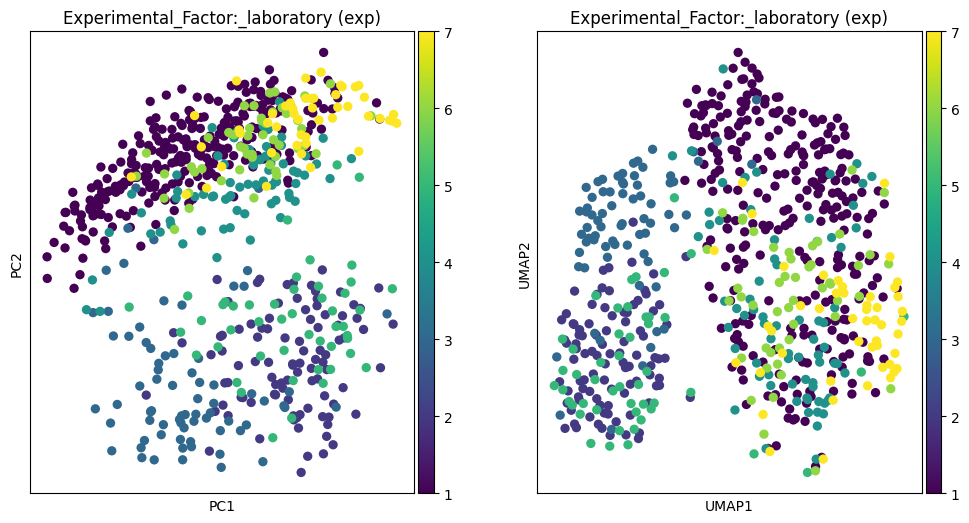

Experimental_Factor:_population (exp)


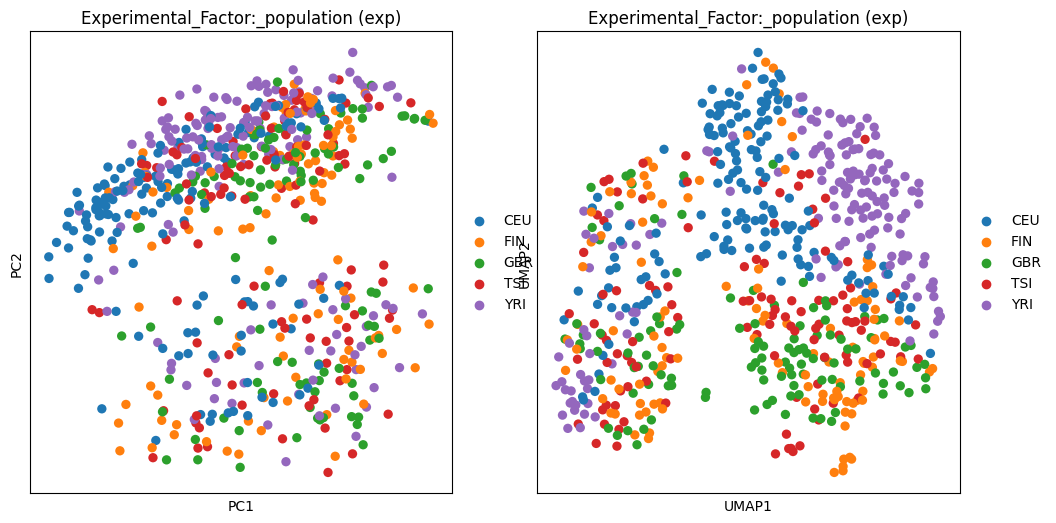

INSDC_first_public


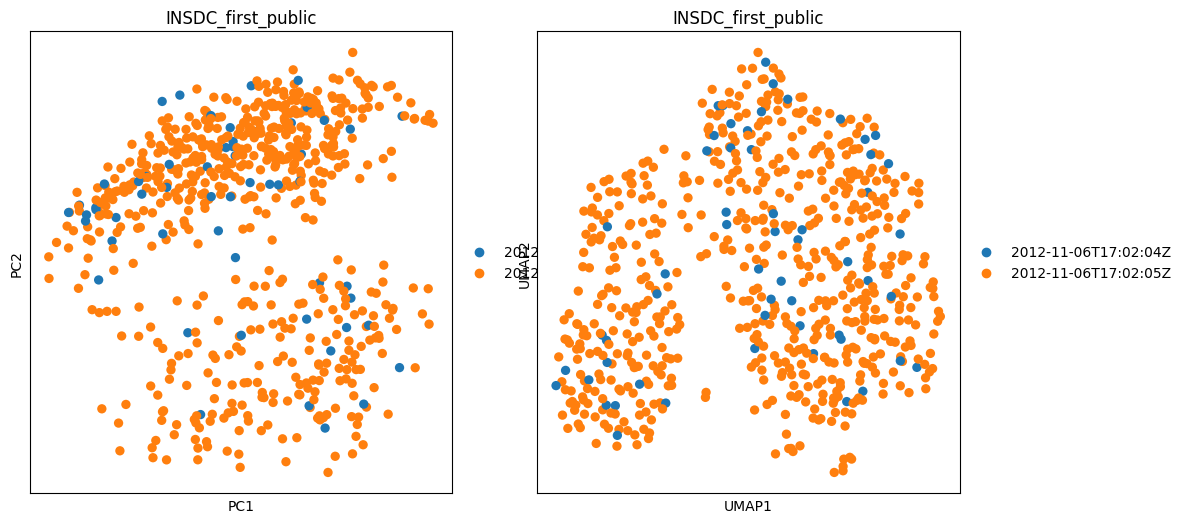

population


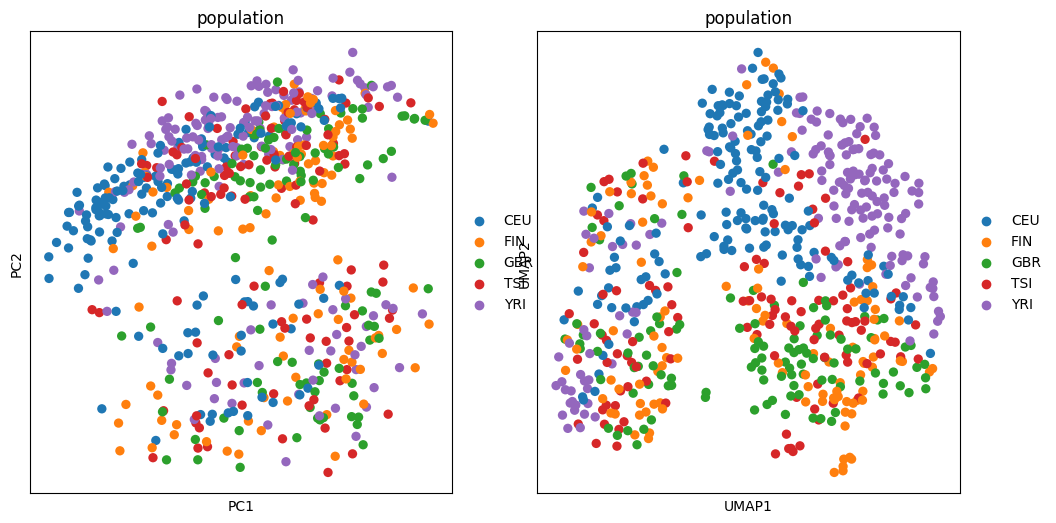

ReleaseDate


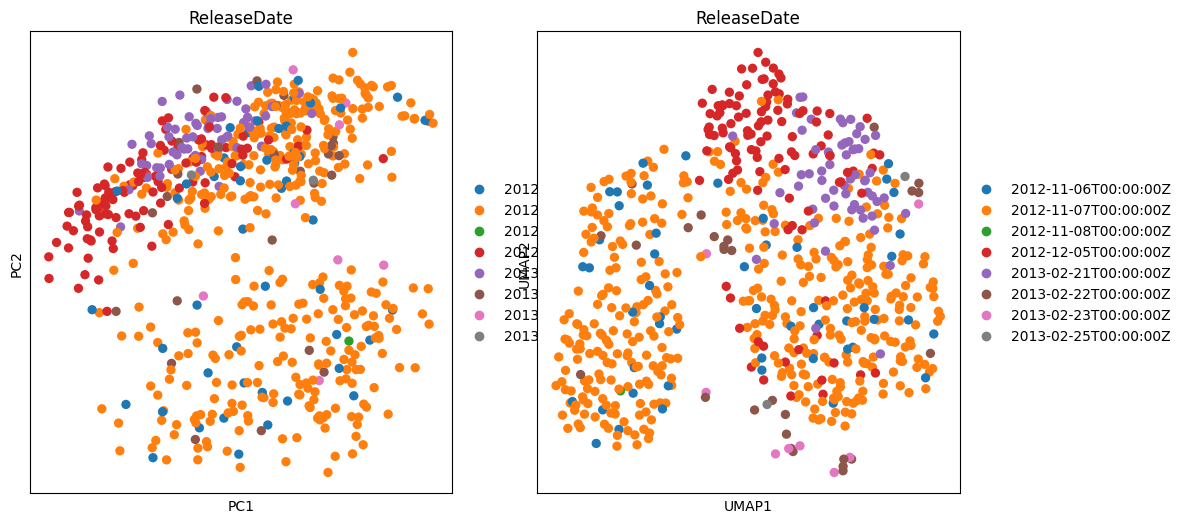

version


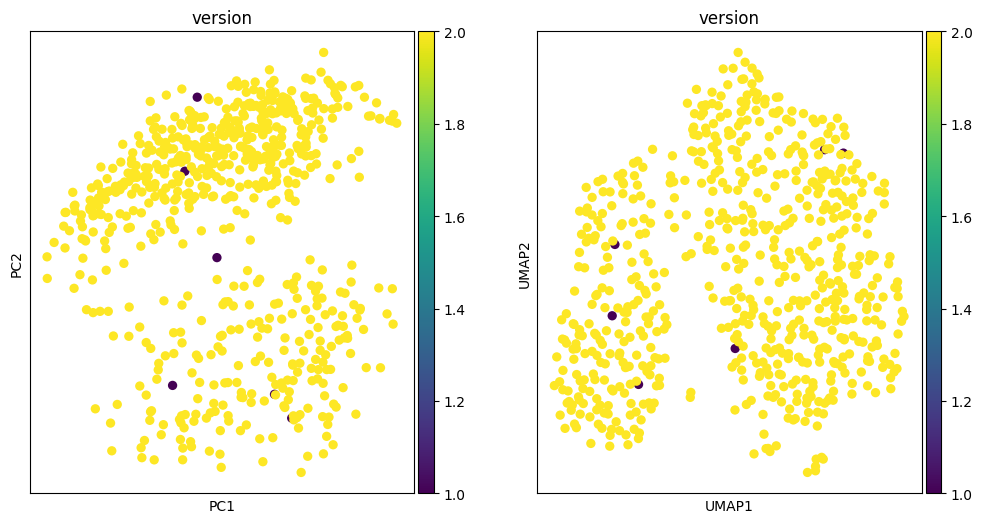

Sex


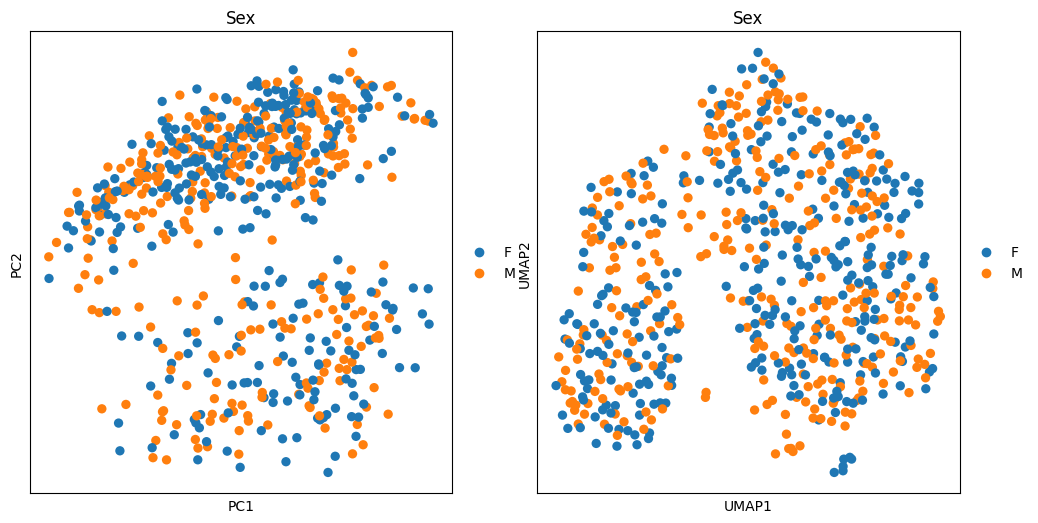

In [33]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

for key in adata.obs_keys():
    # print(len(adata.obs[key].unique()))
    if 1 < len(adata.obs[key].unique()) < 10:
        fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(12,6))
        print(key)
        sc.pl.pca(adata, color=key, ax=axs[0], show=False)
        sc.pl.umap(adata, color=key, ax=axs[1], show=True)
        plt.show()


In [ ]:
adata.obs['Center Name']

adata.obs['batch'] = 0

adata.obs['batch'].loc[adata.obs['Center Name'] == "CNAG"] = 0
adata.obs['batch'].loc[adata.obs['Center Name'] == "CRG"] = 0
adata.obs['batch'].loc[adata.obs['Center Name'] == "HMGU"] = 0+1
adata.obs['batch'].loc[adata.obs['Center Name'] == "MPIMG"] = 0+2

adata.obs['batch'].loc[adata.obs['Center Name'] == "ICMB"] = 1+2
adata.obs['batch'].loc[adata.obs['Center Name'] == "LUMC"] = 1+3
adata.obs['batch'].loc[adata.obs['Center Name'] == "UNIGE"] = 1+4
adata.obs['batch'].loc[adata.obs['Center Name'] == "UU"] = 1+5

# adata.obs['batch'] = adata.obs['AvgSpotLen']
adata.obs['batch']

In [ ]:
import bbknn
# Experimental_Factor:_laboratory (exp), Center Name

# batch_key = "Center Name"
batch_key = "batch"

# sc.tl.pca(adata)

bbknn.bbknn(adata, batch_key=batch_key)
sc.tl.leiden(adata)
bbknn.ridge_regression(adata, batch_key=[batch_key], confounder_key=['leiden'])
sc.tl.pca(adata)
bbknn.bbknn(adata, batch_key=batch_key)

del adata.obsm
# sc.tl.pca(adata)
# sc.tl.umap(adata)

# adata.obsm

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

for key in adata.obs_keys():
    # print(len(adata.obs[key].unique()))
    if 1 < len(adata.obs[key].unique()) < 10:
        fig, axs = plt.subplots(ncols=2, nrows=1,  figsize=(12,6))
        print(key)
        sc.pl.pca(adata, color=key, ax=axs[0], show=False)
        sc.pl.umap(adata, color=key, ax=axs[1], show=True)
        plt.show()

In [ ]:
result_dict = {}
cm_total = np.zeros((5,5))

for organ in ['HEART']:
    result_dict[organ] = {}
    # for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    for sex in ['chrXY']:
        result_dict[organ][sex] = {}

        print("*" * 20)
        print(organ)
        print(model_type)
        print(sex)
        print("*" * 20)
        
        with open(ml_models_fdir/f'{model_type}.json', 'r') as file:
            model_params = json.load(file)
        model_params = model_params[value_to_predict]

        data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)

        features = pd.read_hdf(
            fdir_processed / f'feature_importance.{model_type}.{"Sex"}.organ_{organ}.h5',
            key=f'{sex}',
        )
        features = features[feature_importance_method]
        # features = features.sort_values(ascending=False)
        
        if organ != "None":
            fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
            fname = fname.name

            data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
            features = features.loc[features.index.intersection(data_eval.columns)]
            features = features.sort_values(ascending=False)
            
        features_list = features
        
        data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
        
        # data = data[features_list.index]
        data = data[features_selected]
        
        # features = data.columns
    

        X = data.values
        y = data_header[value_to_predict]

        label_encoder = LabelEncoder().fit(y)
        y = label_encoder.transform(y)

        # label_encoder = OneHotEncoder().fit(pd.DataFrame(y))
        # y = y.astype('category')        

        cv = StratifiedKFold(n_splits=5)

        # fig, ax = plt.subplots(figsize=(6, 6))
        fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]

            # train_scaler = StandardScaler().fit(X_train)
            # test_scaler = StandardScaler().fit(X_test)

            train_scaler = RobustScaler().fit(X_train)
            test_scaler = RobustScaler().fit(X_test)

            X_train = train_scaler.transform(X_train)
            X_test = test_scaler.transform(X_test)
            
            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test

            # y_val = label_encoder.transform(pd.DataFrame(y_val)).toarray()
            # y_train_= label_encoder.transform(pd.DataFrame(y_train_)).toarray()

            model_params['enable_categorical'] = True

            model = xgb.XGBClassifier(**model_params)
            model.fit(cupy.array(X_train_), y_train_, eval_set=[(X_val, y_val)], verbose=False)

            pred = model.predict(cupy.array(X_test))
            pred_prob = model.predict_proba(cupy.array(X_test))
            
            cm = confusion_matrix(y_test, y_pred=pred)
            cm_total=cm_total+cm
            
            for j in range(pred_prob.shape[1]):
                RocCurveDisplay.from_predictions(
                    LabelBinarizer().fit_transform(y_test)[:,j], pred_prob[:,j],
                    plot_chance_level=True, name=label_encoder.classes_[j],
                    ax=axs[j])

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for i in range(pred_prob.shape[1]):
    RocCurveDisplay.from_predictions(
        LabelBinarizer().fit_transform(y_test)[:,i], pred_prob[:,i],
        plot_chance_level=True,
        ax=axs[i]
)
# features

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, y_pred=pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot()


In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_values.mean(axis=2).shape

In [ ]:
model.classes_, features_list.index

In [ ]:
shap.summary_plot(
    shap_values.mean(axis=2), 
    X_test, 
    # plot_type="bar", 
    class_names=label_encoder.classes_, 
    feature_names= features_list.index
    )

In [ ]:
shap.summary_plot(
    shap_values[..., 0], 
    X_test, 
    # plot_type="bar", 
    class_names=label_encoder.classes_, 
    feature_names= features_list.index
    )

In [ ]:
selected_features_list = []
for i in range(5):
    selected_features = features_list.index[np.argsort(np.abs(shap_values[..., i]).mean(axis=0))[-10:]].tolist()
    selected_features_list.extend(selected_features)
    
features_selected = list(set(selected_features_list))
len(features_selected)

In [ ]:
features_selected

In [ ]:
data_header.head().T

In [ ]:
embedding = umap.UMAP(n_components=4)
# embedding = PCA(4)
X_embedded = embedding.fit_transform(StandardScaler().fit_transform(X))

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_header['population'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_header['population'], ax=axs[1])
# plt.show()

In [89]:
fname = next((fdir_external / "BRAIN1" / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / "BRAIN1" / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / "BRAIN1" / 'reg' / 'SraRunTable.txt', sep=',')

In [ ]:
# data_eval_header.head().T
data_header.head().T

In [ ]:
# embedding = umap.UMAP(n_components=4)
embedding = PCA(4)
# X_embedded = embedding.fit_transform(RobustScaler().fit_transform(data_eval.values))
X_embedded = embedding.fit_transform(data_eval.values)

fig, axs = plt.subplots(ncols=2, nrows=1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data_eval_header['RACE'], ax=axs[0])
sns.scatterplot(x=X_embedded[:, 2], y=X_embedded[:, 3], hue=data_eval_header['RACE'], ax=axs[1])
# plt.show()